### 1. Load Dataset

In [1]:
# Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [56]:
df = pd.read_csv('/home/santanu/code/sjchem/bank-account-fraud-detection/raw_data/Base.csv')


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 32 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   fraud_bool                        1000000 non-null  int64  
 1   income                            1000000 non-null  float64
 2   name_email_similarity             1000000 non-null  float64
 3   prev_address_months_count         1000000 non-null  int64  
 4   current_address_months_count      1000000 non-null  int64  
 5   customer_age                      1000000 non-null  int64  
 6   days_since_request                1000000 non-null  float64
 7   intended_balcon_amount            1000000 non-null  float64
 8   payment_type                      1000000 non-null  object 
 9   zip_count_4w                      1000000 non-null  int64  
 10  velocity_6h                       1000000 non-null  float64
 11  velocity_24h                      1000

### Modeling update light gbm
Building a strong, leakage-safe baseline fraud model, evaluate it with fraud-appropriate metrics



### Pipeline Architecture
Raw Data
  ↓
Train / Validation Split (time-aware)
  ↓
Feature Selection (locked list)
  ↓
Preprocessing
  ├── LightGBM path (updated)
  
  ↓
Model Training
  ↓
Evaluation (same metrics)


### 2. Train / Validation Split

#### 2.1 Feature Lists

In [59]:
#Updated feature list
df['income_per_age'] = df['income'] / (df['customer_age'].clip(lower=18))

df['credit_utilization'] = (
    df['intended_balcon_amount'] /
    df['proposed_credit_limit'].clip(lower=50)
)

df['velocity_ratio'] = (
    df['velocity_6h'] /
    df['velocity_4w'].clip(lower=1)
)

df['avg_velocity_per_hour'] = df['velocity_24h'] / 24


In [60]:
TARGET = 'fraud_bool'
NUM_COLS = [
    'income','customer_age','credit_risk_score',
    'proposed_credit_limit','intended_balcon_amount',
    'session_length_in_minutes','days_since_request',
    'bank_months_count','zip_count_4w',
    'velocity_6h','velocity_24h','velocity_4w',
    'bank_branch_count_8w','device_distinct_emails_8w',
    'date_of_birth_distinct_emails_4w',
    'current_address_months_count','prev_address_months_count',
    'income_per_age','credit_utilization',
    'velocity_ratio','avg_velocity_per_hour'
]
BIN_COLS = [
    'email_is_free','phone_home_valid','phone_mobile_valid',
    'has_other_cards','foreign_request','keep_alive_session'
]
CAT_COLS =[
    'employment_status','housing_status','payment_type',
    'source','device_os','month'
]

FEATURES = NUM_COLS + BIN_COLS + CAT_COLS

In [61]:
### Trai / Validation Split
train_df = df[df['month'] <= 6]
valid_df = df[df['month'] > 6]


In [62]:
X_train = train_df[FEATURES]
y_train = train_df[TARGET]

X_valid = valid_df[FEATURES]
y_valid = valid_df[TARGET]


#### 2.2 Light GBM Pipeline

In [63]:
for c in CAT_COLS:
    X_train[c] = X_train[c].astype('category')
    X_valid[c] = X_valid[c].astype('category')

/tmp/ipykernel_7584/2017687960.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[c] = X_train[c].astype('category')
/tmp/ipykernel_7584/2017687960.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid[c] = X_valid[c].astype('category')
/tmp/ipykernel_7584/2017687960.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

In [77]:
import lightgbm as lgb

# Calculate scale_pos_weight for class imbalance
#scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
    'num_leaves': 31,
    'max_depth': 6,
    'min_data_in_leaf': 50,
    #'min_child_weight': 5,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.7,
    'bagging_freq': 5,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    #'scale_pos_weight': scale_pos_weight,
    'is_unbalance': True,  # Explicitly handle imbalance
    'verbosity': -1,
    'seed': 42
}

print(f"Scale pos weight: {scale_pos_weight:.2f}")
print(f"Training samples: {len(y_train):,}")
print(f"Fraud rate in train: {y_train.mean():.4f}")


Scale pos weight: 93.07
Training samples: 903,157
Fraud rate in train: 0.0106


In [78]:
lgb_train = lgb.Dataset(
    X_train, y_train,
    categorical_feature=CAT_COLS,
    free_raw_data=False
)

lgb_valid = lgb.Dataset(
    X_valid, y_valid,
    categorical_feature=CAT_COLS,
    free_raw_data=False
)


In [79]:
model = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_valid],
    num_boost_round=5000,
    callbacks=[lgb.early_stopping(stopping_rounds=200), lgb.log_evaluation(period=100)],
)


Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.879312
[200]	valid_0's auc: 0.882816
[300]	valid_0's auc: 0.885903
[400]	valid_0's auc: 0.887794
[500]	valid_0's auc: 0.88923
[600]	valid_0's auc: 0.890254
[700]	valid_0's auc: 0.890904
[800]	valid_0's auc: 0.891245
[900]	valid_0's auc: 0.891689
[1000]	valid_0's auc: 0.89196
[1100]	valid_0's auc: 0.892224
[1200]	valid_0's auc: 0.892576
[1300]	valid_0's auc: 0.892517
[1400]	valid_0's auc: 0.892499
[1500]	valid_0's auc: 0.892705
[1600]	valid_0's auc: 0.892718
[1700]	valid_0's auc: 0.892691
[1800]	valid_0's auc: 0.892636
Early stopping, best iteration is:
[1660]	valid_0's auc: 0.892837


In [80]:
y_pred = model.predict(X_valid)


In [81]:
# PR-AUC (Primary)
from sklearn.metrics import average_precision_score
ap = average_precision_score(y_valid, y_pred)
print(f"PR-AUC: {ap:.4f}")


PR-AUC: 0.2095


In [82]:
# Recall @ Fixed FPR
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_valid, y_pred)
fpr, tpr, thresholds = roc_curve(y_valid, y_pred)
idx = np.where(fpr <= 0.01)[0][-1]

print("Recall @ 1% FPR:", tpr[idx])

Recall @ 1% FPR: 0.27240896358543415


In [83]:
# recision @ Top-K%
k = int(0.01 * len(y_pred))
top_k_idx = np.argsort(y_pred)[-k:]

precision_at_k = y_valid.iloc[top_k_idx].mean()
print("Precision @ top 1%:", precision_at_k)


Precision @ top 1%: 0.3243801652892562


### 2.2.1 Threshold Selection (VERY IMPORTANT)

Default 0.5 is ❌ wrong.

Choose threshold based on:

Fraud ops capacity

Manual review limits

False positive tolerance

In [87]:
threshold = thresholds[idx]
print("Threshold at 1% FPR:", threshold)


Threshold at 1% FPR: 0.8871822583885163


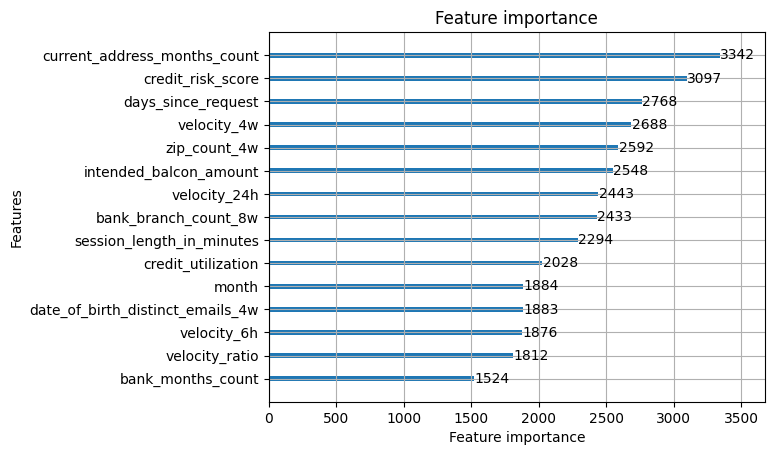

In [88]:
lgb.plot_importance(model, max_num_features=15)
plt.show()

In [89]:
from sklearn.metrics import average_precision_score, roc_auc_score, roc_curve
import numpy as np

# Evaluate LightGBM model
print("=" * 60)
print("LIGHTGBM MODEL EVALUATION")
print("=" * 60)

# Get predictions
lgb_pred = model.predict(X_valid)

# Calculate metrics
lgb_pr_auc = average_precision_score(y_valid, lgb_pred)
lgb_roc_auc = roc_auc_score(y_valid, lgb_pred)

print("\n📊 Performance Metrics:")
print(f"PR-AUC:  {lgb_pr_auc:.4f}")
print(f"ROC-AUC: {lgb_roc_auc:.4f}")

# Recall at 1% FPR
fpr_lgb, tpr_lgb, _ = roc_curve(y_valid, lgb_pred)
idx_lgb = np.where(fpr_lgb <= 0.01)[0][-1]
recall_lgb = tpr_lgb[idx_lgb]
print(f"Recall @ 1% FPR: {recall_lgb:.4f}")

LIGHTGBM MODEL EVALUATION

📊 Performance Metrics:
PR-AUC:  0.2095
ROC-AUC: 0.8928
Recall @ 1% FPR: 0.2724


In [95]:
import os
import pickle


# Save LightGBM model
model.save_model('/home/santanu/code/sjchem/bank-account-fraud-detection/models/lgb_modified.txt')

# Alternatively, save using pickle for full object serialization
with open('/home/santanu/code/sjchem/bank-account-fraud-detection/models/lgb_modified.pkl', 'wb') as f:
    pickle.dump(model, f)

print("LightGBM modified model saved successfully!")
print("- Text format: models/lgb_modified.txt")
print("- Pickle format: models/lgb_modified.pkl")

LightGBM modified model saved successfully!
- Text format: models/lgb_modified.txt
- Pickle format: models/lgb_modified.pkl


In [104]:
import pickle

# Load and compare base and modified LightGBM models

# Load both models
with open('/home/santanu/code/sjchem/bank-account-fraud-detection/models/lgb_base_model.pkl', 'rb') as f:
    model_base = pickle.load(f)

with open('/home/santanu/code/sjchem/bank-account-fraud-detection/models/lgb_modified.pkl', 'rb') as f:
    model_modified = pickle.load(f)

# Get predictions from both models
y_pred_base = model_base.predict(X_valid)
y_pred_modified = model_modified.predict(X_valid)

# Compare performance
print("=" * 60)
print("MODEL COMPARISON: BASE vs MODIFIED")
print("=" * 60)

# PR-AUC comparison
pr_auc_base = average_precision_score(y_valid, y_pred_base)
pr_auc_modified = average_precision_score(y_valid, y_pred_modified)

print(f"\nPR-AUC:")
print(f"  Base Model:     {pr_auc_base:.4f}")
print(f"  Modified Model: {pr_auc_modified:.4f}")
print(f"  Improvement:    {pr_auc_modified - pr_auc_base:+.4f}")

# ROC-AUC comparison
roc_auc_base = roc_auc_score(y_valid, y_pred_base)
roc_auc_modified = roc_auc_score(y_valid, y_pred_modified)

print(f"\nROC-AUC:")
print(f"  Base Model:     {roc_auc_base:.4f}")
print(f"  Modified Model: {roc_auc_modified:.4f}")
print(f"  Improvement:    {roc_auc_modified - roc_auc_base:+.4f}")

# Recall @ 1% FPR comparison
fpr_base, tpr_base, _ = roc_curve(y_valid, y_pred_base)
idx_base = np.where(fpr_base <= 0.01)[0][-1]
recall_base_1pct = tpr_base[idx_base]

fpr_modified, tpr_modified, _ = roc_curve(y_valid, y_pred_modified)
idx_modified = np.where(fpr_modified <= 0.01)[0][-1]
recall_modified_1pct = tpr_modified[idx_modified]

print(f"\nRecall @ 1% FPR:")
print(f"  Base Model:     {recall_base_1pct:.4f}")
print(f"  Modified Model: {recall_modified_1pct:.4f}")
print(f"  Improvement:    {recall_modified_1pct - recall_base_1pct:+.4f}")

# Precision @ Top 1%
k = int(0.01 * len(y_pred_base))
top_k_idx_base = np.argsort(y_pred_base)[-k:]
precision_base_1pct = y_valid.iloc[top_k_idx_base].mean()

top_k_idx_modified = np.argsort(y_pred_modified)[-k:]
precision_modified_1pct = y_valid.iloc[top_k_idx_modified].mean()

print(f"\nPrecision @ Top 1%:")
print(f"  Base Model:     {precision_base_1pct:.4f}")
print(f"  Modified Model: {precision_modified_1pct:.4f}")
print(f"  Improvement:    {precision_modified_1pct - precision_base_1pct:+.4f}")

print("\n" + "=" * 60)

MODEL COMPARISON: BASE vs MODIFIED

PR-AUC:
  Base Model:     0.2099
  Modified Model: 0.2095
  Improvement:    -0.0004

ROC-AUC:
  Base Model:     0.8927
  Modified Model: 0.8928
  Improvement:    +0.0002

Recall @ 1% FPR:
  Base Model:     0.2752
  Modified Model: 0.2724
  Improvement:    -0.0028

Precision @ Top 1%:
  Base Model:     0.3244
  Modified Model: 0.3244
  Improvement:    +0.0000



### Explainability & SHAP (Fraud-Grade)

In [109]:
import shap
import numpy as np


/home/santanu/.pyenv/versions/bank-account-fraud-detection/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [111]:
explainer = shap.TreeExplainer(model_base)


In [112]:
X_valid_sample = X_valid.sample(
    n=5000,
    random_state=42
)
shap_values = explainer.shap_values(X_valid_sample)

/home/santanu/.pyenv/versions/bank-account-fraud-detection/lib/python3.10/site-packages/shap/explainers/_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


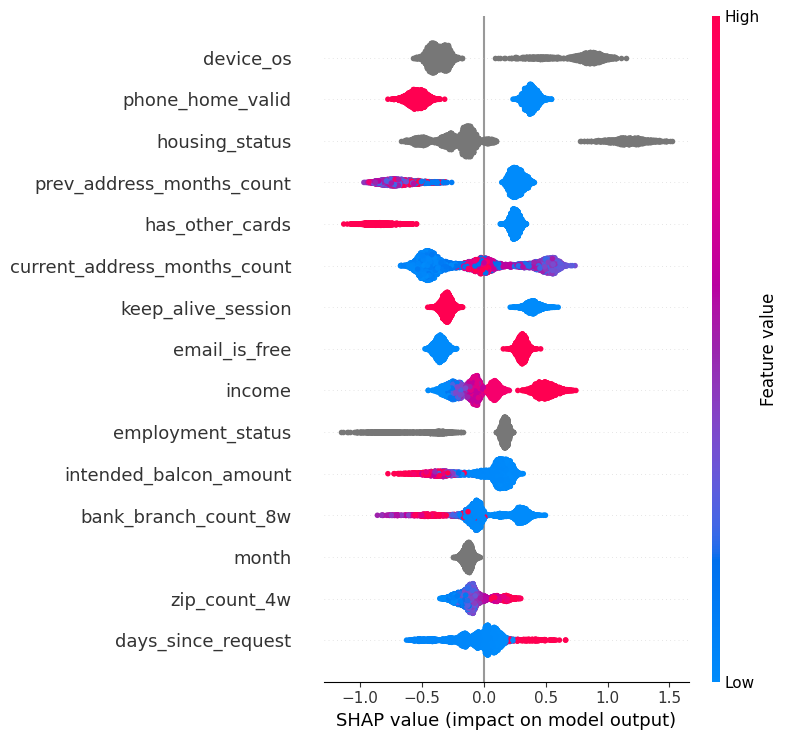

In [114]:
shap.summary_plot(
    shap_values,
    X_valid_sample,
    plot_type="dot",
    max_display=15
)


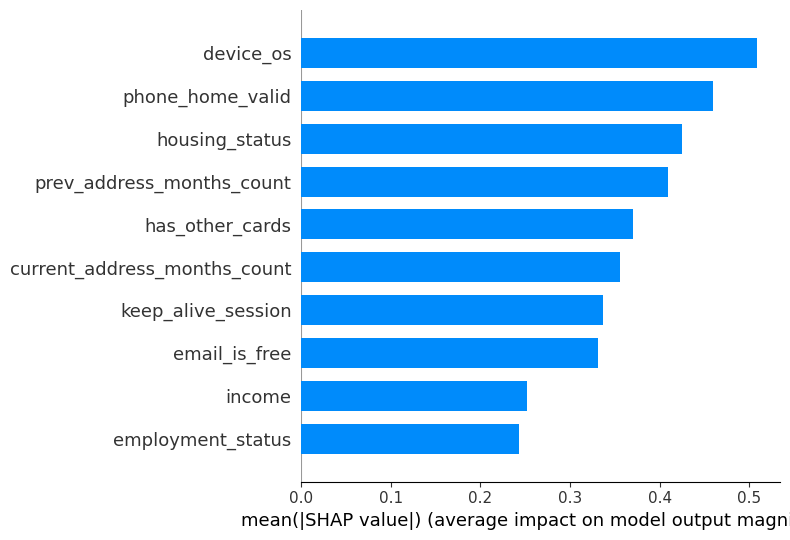

In [115]:
shap.summary_plot(
    shap_values,
    X_valid_sample,
    plot_type="bar",
    max_display=10
)


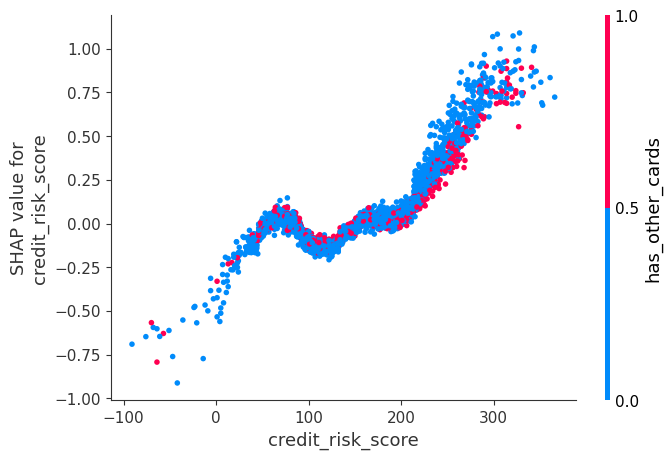

In [117]:
shap.dependence_plot(
    'credit_risk_score',
    shap_values,
    X_valid_sample
)


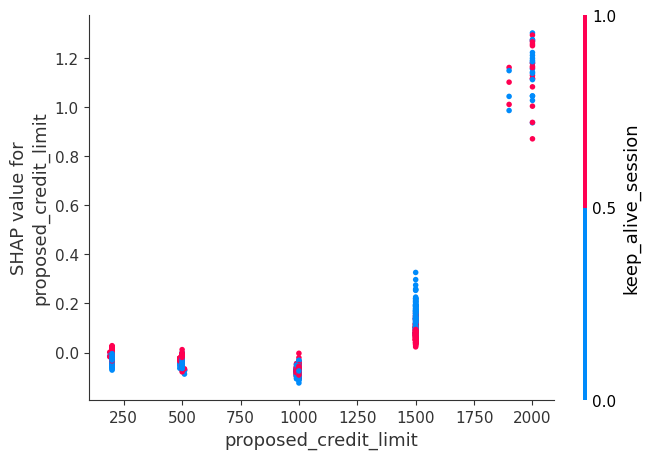

In [118]:
shap.dependence_plot(
    'proposed_credit_limit',
    shap_values,
    X_valid_sample
)
